# Comparison of reference matching algorithms

Dominika Tkaczyk

13.10.2018

This file contains the the comparison of two approaches to bibliographic reference matching:
  * **STQ**: the current approach based on Simple Text Query form
  * **SBM**: the new idea based on the search API

STQ is based on regular expressions and reference parsing.

SBM is a very simple algorithm, which doesn't include any reference parsing step. In SBM the entire reference string is used as a query in the search engine. The first hit is returned as the matched target document, if its relevance score is high enough. If the relevance score of the first hit is low, no target DOI is assigned and the reference string stays unmatched.

The goal of this analysis is to evaluate and compare both STQ and SBM.

## TL;DR

  * A larget artificial dataset was used for the experiments.
  * The main metrics are precision, recall and F1 averaged over a sample of target documents.
  * Two variations of SBM were tested: SBM with a simple relevance threshold of 53 and SBM with a normalized relevance threshold of 0.47
  * In general, STQ is better than SBM in precision, but worse in recall and F1.
  * SBM with a simple relevance threshold outperforms STQ (F1 76% vs. 49%)
  * SBM with a normalized relevance threshold outperforms STQ (F1 81% vs. 49%)
  * SBM with a simple relevance threshold outperforms STQ in 8 styles out of 11
  * SBM with a normalized relevance threshold outperforms STQ in all 11 styles

## Methodology

We need two things to evaluate and compare the algorithms: the dataset and the metrics.

### The dataset

The dataset used for experiments was generated automatically using the following workflow.

First, I took a random sample of 2500 items from the system. (This number was chosen as big enough to give reliable results and small enough to handle the current STQ form limits.) This is my base sample.

Second, I extended the sample by adding up to 2 similar documents for each item in the sample. Similar documents were found by selecting the highest hits from the search results. As a search query I used the concatenation of the title, container title and family names of all the authors. This step was performed to increase the probability of incorrect links pointing to the base sample (ie. to have a non-zero false positive rate). Extending the dataset resulted in 7374 items in total (fewer than 3 x the original sample size, because for some documents fewer than 2 similar documents could be found).

Next, reference strings were generated for all items. In this experiment, I used the following 11 styles:
  * normal styles:
    * **american-chemical-society**
    * **american-institute-of-physics**
    * **elsevier-without-titles**
    * **apa**
    * **chicago-author-date**
    * **modern-language-association**
  * normal styles + random noise added to the reference strings (additional spaces, missing spaces, typos):
    * **apa+noise**
    * **american-institute-of-physics+noise**
  * custom "styles":
    * **degraded_all_authors**: a simple concatenation of authors' names, title and container title
    * **degraded_one_author**: a simple concatenation of the first author's name, title and container title
    * **degraded_title_scrambled**: same as degraded_all_authors, but with title words randomly shuffled
 
Finally, each string was passed to both reference matching algorithms and the returned matched DOIs were recorded. For SBM I also kept the resulting relevance scores, so that it is possible to apply any relevance score threshold after.

### The metrics


To evaluate and compare the algorithms, I used averaged document-based metrics. More specifically, for each document from the base sample the following metrics are calculated:
  * **precision**: what fraction of links to document X returned by the matching algorithm are correct (or: what is the probability that the link to document X returned by the algorithm is correct)
  * **recall**: what fraction of true expected links to document X were returned by the algorithm (or: what is the probability that the true link to document X will be returned by the algorithm)
  * **F1**: harmonic mean of precision and recall

These numbers are then averaged over all 2500 documents from the base sample. The averages can be treated as single-number metrics, and the distributions of the results over the documents allow to calculate the confidence intervals. 

More information about the metrics can be found here: https://docs.google.com/document/d/1X0clkjH-HM3DLVPWDgAZgS97Th4slniq28F9o-yd53k More information about the foundations of sampling and confidence intervals can be found in this notebook: https://notebooks.labs.crossref.org/user/dtkaczyk/notebooks/dtkaczyk/sampling_notes.ipynb

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from evaluation.document_metrics import ByDocumentMetricsResults
from evaluation.split_metrics import SplitByRefAttrResults
from utils.utils import read_json

DATA_DIR = '../data/comparison/'
STYLES = ['american-chemical-society', 'american-institute-of-physics', 'american-institute-of-physics-noise', 'apa',
          'apa-noise', 'chicago-author-date', 'degraded_all_authors', 'degraded_one_author',
          'degraded_title_scrambled', 'elsevier-without-titles', 'modern-language-association']

Let's now read the data:

In [2]:
def read_data():
    datasets = {}
    for algo in ['sa', 'stq']:
        datasets[algo] = []
        for style in STYLES:
            d = read_json(DATA_DIR + 'matched/matched-' + algo + '-' + style + '.json')
            dois = d[dfk.DATASET_DOIS]
            datasets[algo].extend(d[dfk.DATASET_DATASET])
    datasets['sbm'] = datasets['sa']
    datasets.pop('sa')
    return datasets, dois

datasets, dois = read_data()
print({a: len(d) for a, d in datasets.items()})

{'stq': 81114, 'sbm': 81114}


*dois* is the list of 2500 DOIs from the original sample. We will need it for the evaluation.

In [3]:
print('Size of the base sample: {}'.format(len(dois)))

Size of the base sample: 2500


Let's first look at the overall averaged results for all the citation styles combined into a single dataset, for STQ and SBM algorithms, respectively:

In [4]:
def print_summary(results, name):
    for av, ci, metric in results.metrics_groups:
        print('Average {} for {} algorithm: {:.4f} (confidence interval (95%): {:.4f} - {:.4f})'
              .format(metric, name, results.get(av), results.get(ci)[0], results.get(ci)[1]))

In [5]:
results_stq = ByDocumentMetricsResults(datasets['stq'], dois)
results_style_stq = SplitByRefAttrResults(datasets['stq'], 'style', dois)
print_summary(results_stq, 'STQ')

Average precision for STQ algorithm: 0.9932 (confidence interval (95%): 0.9908 - 0.9955)
Average recall for STQ algorithm: 0.3820 (confidence interval (95%): 0.3716 - 0.3924)
Average F1 for STQ algorithm: 0.4905 (confidence interval (95%): 0.4781 - 0.5028)


In [6]:
results_sbm_0 = ByDocumentMetricsResults(datasets['sbm'], dois)
results_style_sbm_0 = SplitByRefAttrResults(datasets['sbm'], 'style', dois)
print_summary(results_sbm_0, 'SBM (t=0)')

Average precision for SBM (t=0) algorithm: 0.9803 (confidence interval (95%): 0.9770 - 0.9836)
Average recall for SBM (t=0) algorithm: 0.8484 (confidence interval (95%): 0.8381 - 0.8587)
Average F1 for SBM (t=0) algorithm: 0.8737 (confidence interval (95%): 0.8642 - 0.8832)


STQ has a slightly better precision than SBM (99.32% vs. 98.03%), but much smaller recall (38.20% vs. 84.84%). STQ's small recall suggests that STQ is very conservative and as a result, misses quite a few links.

High precision values are related to the limitation of the dataset. Since we included only 2 similar documents for each document in the sample, the possibility of incorrectly matching them to our sample is still quite limited.

The confidence intervals give us the ranges of values, where we expect the real averages to be. For example, statistically speaking, we are 95% sure that the real average recall for SBM in the system is between 83.81% and 85.87%.

Of course, the results of SBM are reported here are not entirely fair, because we didn't apply any relevance score threshold. Since all input reference strings have a target document in the system, the results are most likely higher that with a threshold. In practise, of course, we will have to apply a threshold.

Let's calculate the overall  results also for the best values of simple and normalized threshold, calculated in the analysis "The relevance score threshold". These functions will modify the dataset according to the simple or normalized threshold:

In [7]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

In [8]:
def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's calculate the results for the best simple threshold of 53:

In [9]:
datasets, _ = read_data()
datasets['sbm'] = modify_simple_threshold(datasets['sbm'], 53)
results_sbm_53 = ByDocumentMetricsResults(datasets['sbm'], dois)
results_style_sbm_53 = SplitByRefAttrResults(datasets['sbm'], 'style', dois)
print_summary(results_sbm_53, 'SBM (t=53)')

Average precision for SBM (t=53) algorithm: 0.9840 (confidence interval (95%): 0.9809 - 0.9871)
Average recall for SBM (t=53) algorithm: 0.6835 (confidence interval (95%): 0.6723 - 0.6948)
Average F1 for SBM (t=53) algorithm: 0.7592 (confidence interval (95%): 0.7485 - 0.7699)


And here we have the results for the normalized best threshold of 0.47:

In [10]:
datasets, _ = read_data()
datasets['sbm'] = modify_norm_threshold(datasets['sbm'], 0.47)
results_sbm_047 = ByDocumentMetricsResults(datasets['sbm'], dois)
results_style_sbm_047 = SplitByRefAttrResults(datasets['sbm'], 'style', dois)
print_summary(results_sbm_047, 'SBM (tnorm=0.47)')

Average precision for SBM (tnorm=0.47) algorithm: 0.9814 (confidence interval (95%): 0.9782 - 0.9846)
Average recall for SBM (tnorm=0.47) algorithm: 0.7611 (confidence interval (95%): 0.7497 - 0.7726)
Average F1 for SBM (tnorm=0.47) algorithm: 0.8102 (confidence interval (95%): 0.7995 - 0.8209)


Let's compare the overall results using a single plot:

In [11]:
def get_means(results):
    return [results.get(m) for m in [dfk.EVAL_MEAN_PREC, dfk.EVAL_MEAN_REC, dfk.EVAL_MEAN_F1]]

def get_ses(results):
    return [(results.get(m)[1]-results.get(m)[0])/2 for m in [dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC, dfk.EVAL_CI_F1]]

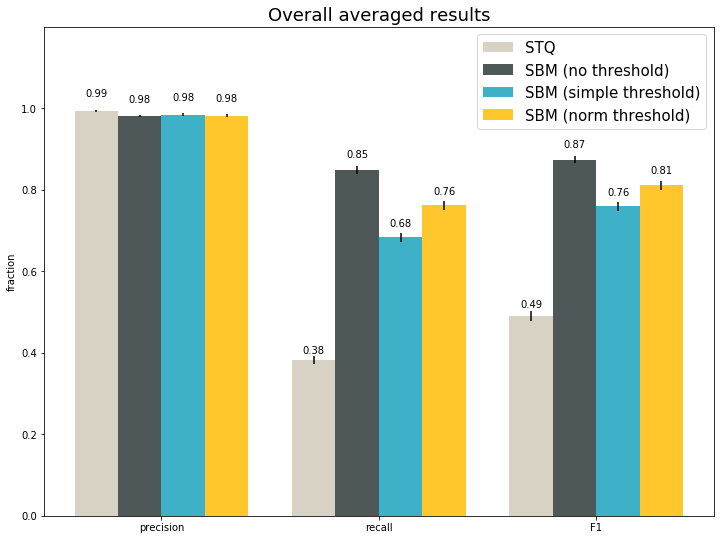

In [12]:
def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 10})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

ind = np.arange(3)
width = 0.2
fig, ax = plt.subplots(figsize=(12, 9))
plt.rcParams.update({'font.size': 15}) 

rects1 = ax.bar(ind - width, get_means(results_stq), width, color='#d8d2c4', yerr=get_ses(results_stq))
rects2 = ax.bar(ind, get_means(results_sbm_0), width, color='#4f5858', yerr=get_ses(results_sbm_0))
rects3 = ax.bar(ind + width, get_means(results_sbm_53), width, color='#3eb1c8', yerr=get_ses(results_sbm_53))
rects4 = ax.bar(ind + 2*width, get_means(results_sbm_047), width, color='#ffc72c', yerr=get_ses(results_sbm_047))

ax.set_ylabel('fraction')
ax.set_title('Overall averaged results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
          ('STQ', 'SBM (no threshold)', 'SBM (simple threshold)', 'SBM (norm threshold)'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)

plt.show() 

We can see that STQ is still the worst approach, accorsing to F1. The best is SBM without any threshold (which is not a practical approach). Normalized threshold results in better overall F1 than simple threshold.

Let's also plot similar comparison for each style separately. 

In [13]:
def get_results_style(results, style):
    results = results.get(dfk.EVAL_SPLIT_METRICS)
    results = results.iloc[:,[7,8,9]][results['style'] == style]
    return list(results.to_records(index=False)[0])

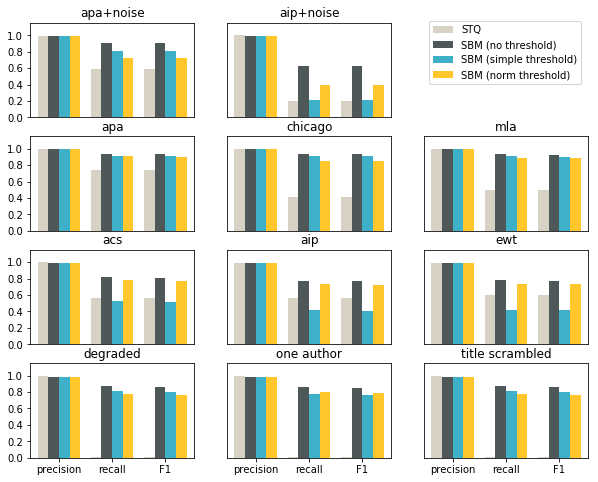

In [14]:
f, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 8))
ind = np.arange(3)
width = 0.2

styles = [['apa-noise', 'american-institute-of-physics-noise'],
          ['apa', 'chicago-author-date', 'modern-language-association'],
          ['american-chemical-society', 'american-institute-of-physics', 'elsevier-without-titles'],
          ['degraded_all_authors', 'degraded_one_author', 'degraded_title_scrambled']]
titles = [['apa+noise', 'aip+noise'],
          ['apa', 'chicago', 'mla'],
          ['acs', 'aip', 'ewt'],
          ['degraded', 'one author', 'title scrambled']]

for i in range(4):
    for j in range(3):
        if len(styles) <= i or len(styles[i]) <= j:
            continue
        rects1 = axes[i, j].bar(ind-width, get_results_style(results_style_stq, styles[i][j]), width, color='#d8d2c4')
        rects2 = axes[i, j].bar(ind, get_results_style(results_style_sbm_0, styles[i][j]), width, color='#4f5858')
        rects3 = axes[i, j].bar(ind+width, get_results_style(results_style_sbm_53, styles[i][j]), width, color='#3eb1c8')
        rects4 = axes[i, j].bar(ind+2*width, get_results_style(results_style_sbm_047, styles[i][j]), width, color='#ffc72c')
        axes[i, j].set_title(titles[i][j])

axes[0, 0].set_xticks(ind + width / 2)
axes[0, 0].set_xticklabels(('precision', 'recall', 'F1'))
axes[0, 2].legend((rects1[0], rects2[0], rects3[0], rects4[0]),
                  ('STQ', 'SBM (no threshold)', 'SBM (simple threshold)', 'SBM (norm threshold)'),
                  loc=3, bbox_to_anchor=(0, 0.3))

for i in range(3):
    for j in range(3):
        axes[i, j].xaxis.set_ticks_position('none') 
for i in range(4):
    for j in [1,2]:
        axes[i, j].yaxis.set_ticks_position('none')
axes[0, 2].axis('off')

plt.ylim(0, 1.15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

As we can see, SBM with no threshold outperforms STQ for every style. SBM with a simple threshold is worse than STQ for styles that do not include the title (acs, aip, ewt). SBM with a normalized threshold is worse than SBM with no threshold, but in every case better than STQ.